In [1]:
import json
import logging
import base64
import matplotlib.pyplot as plt
from openai import OpenAI
from PIL import Image
from io import BytesIO

from AgentFactory import AgentFactory
from src.utils import clear_json

logging.basicConfig(level=logging.INFO)


/home/youyuan/miniconda3/envs/Iris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading the _Concept_ Dataset

In [2]:
from assets.concept.transcreation_dataset import TranscreationDataset

dataset = TranscreationDataset("assets/concept/")
print(dataset['india']["japan"][0])


path: https://storage.googleapis.com/image-transcreation/part1/india/beverages_kingfisher-beer.jpg
country_from: india
country_to: japan
src_culture_score: 1.0
src_offensive_score: 1.0
caption: None
caption_edited: None
	 Transcreations 0:https://storage.googleapis.com/image-transcreation/outputs/part1/e2e-instruct/japan/india_beverages_kingfisher-beer.jpg
	 Transcreations 1:https://storage.googleapis.com/image-transcreation/outputs/part1/cap-retrieve/japan/india_beverages_kingfisher-beer.jpg
	 Transcreations 2:https://storage.googleapis.com/image-transcreation/outputs/part1/cap-edit/japan/india_beverages_kingfisher-beer.png



./download_images//image-transcreation/part1/india/beverages_kingfisher-beer.jpg


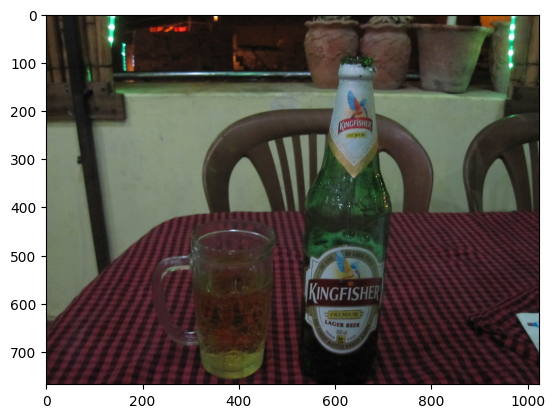

In [3]:
from src.WebImage import WebImage

image_handler = WebImage(country_f="india", country_t="japan")
local_path = image_handler.read_image_fp(dataset['india']["japan"][0]["path"])
print(local_path)

img = Image.open(local_path)
plt.imshow(img)


### Loading a Agent

In [8]:
agent_factory = AgentFactory()

# config_path: str = "configs/conf_Gemini.json"
config_path: str = "configs/conf_GPT.json"
config = json.load(open(config_path, "r"))
config = config["model"]

agent = agent_factory.create_agent(config)
agent.instruction = config["system_msg"]

In [9]:
# agent.reset_msg_history()

prompt = [
            {"type": "text", "text": "Please caption the following images and extract all the objects respectively.\n"},
            {"type": "image"},
            {"type": "text", "text": "Please answer in the follwing json format.\n"},
            {"type": "text", "text": "[\n"},
            {"type": "text", "text": "{\n"},
            {"type": "text", "text": "'caption':'...',\n"},
            {"type": "text", "text": "'objects':['obj1', 'obj2', ...]\n"},
            {"type": "text", "text": "},\n"},
            {"type": "text", "text": "...\n"},
            {"type": "text", "text": "]\n"},
        ]
images = [local_path]

response, text = agent.get_response(prompt, images = images)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


In [10]:
# print(response)
print(text)
print ("Total cost: ", agent.llm.total_cost())

```json
[
  {
    "caption": "A bottle of Kingfisher beer and a glass mug with beer on a table with a checkered tablecloth.",
    "objects": ["beer bottle", "glass mug", "table", "tablecloth", "chairs", "plant pots", "decor lights"]
  }
]
```
Total cost:  0.0055000000000000005


In [ ]:
# prompt_caption = [
#             {"type": "text", "text": "Please rewrite the caption by replacing Indian cultural elements with equivalent Japanese ones, while keeping the original meaning.\n"},
#         ]
prompt_caption = [
            {"type": "text", "text": "Please give the instrution on how to edit the image to make it familiar to Japanese, while keeping the original meaning.\n"},
        ]
response, text = agent.get_response(prompt_caption)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


In [12]:
print(text)
print ("Total cost: ", agent.llm.total_cost())
json_obj = json.loads(clear_json(text))
edited_caption = json_obj[0]["caption"]
print(edited_caption)

```json
[
  {
    "caption": "A bottle of Asahi beer and a glass mug with beer on a table with a checkered tablecloth.",
    "objects": ["beer bottle", "glass mug", "table", "tablecloth", "chairs", "plant pots", "decor lights"]
  }
]
```
Total cost:  0.011460000000000001
A bottle of Asahi beer and a glass mug with beer on a table with a checkered tablecloth.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/images/edits "HTTP/1.1 200 OK"


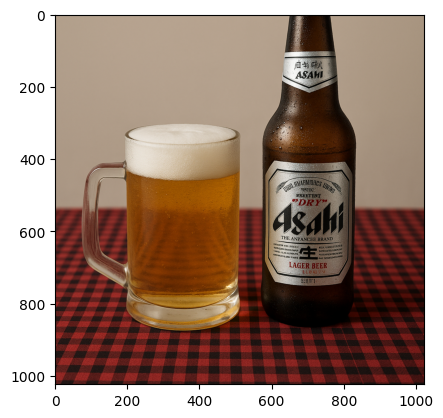

In [ ]:

client = OpenAI(
    api_key=config["api_key"],
)

prompt_generation = f"""
Generate a photorealistic image following the caption:{edited_caption}
"""

prompt_edition = f"""
{edited_caption}
"""

# result = client.images.generate(
#     model = "dall-e-3",
#     prompt = prompt_generation,
#     response_format = "b64_json"
# )

result = client.images.edit(
    model="gpt-image-1", 
    image=[
        open(local_path, "rb"),
    ],
    prompt=prompt_edition
)

image_base64 = result.data[0].b64_json
image_bytes = base64.b64decode(image_base64)

image = Image.open(BytesIO(image_bytes))
plt.imshow(image)
